# Detecção de Fraudes em Transações Bancárias com Isolation Forest

## Visão Geral do Projeto

Este projeto tem como objetivo principal o desenvolvimento de um sistema de machine learning para a detecção de transações fraudulentas em cartões de crédito em tempo real. A detecção de fraudes é um desafio crítico para instituições financeiras, e a aplicação de algoritmos de detecção de anomalias se mostra uma abordagem eficaz para identificar padrões suspeitos que fogem do comportamento transacional padrão dos usuários.

Utilizaremos uma abordagem de aprendizado não supervisionado, com foco no algoritmo **Isolation Forest**, que é particularmente eficiente para identificar outliers (anomalias) em grandes conjuntos de dados. A ideia central é que transações fraudulentas são eventos raros e diferentes, o que as torna mais fáceis de "isolar" do que as transações normais.

## Dataset

Para este projeto, utilizaremos o dataset "Credit Card Fraud Detection" disponível na plataforma Kaggle. Este conjunto de dados contém transações realizadas por portadores de cartões europeus em setembro de 2013. Ele abrange um período de dois dias e apresenta uma alta disparidade entre as classes, com 492 fraudes em um total de 284.807 transações, o que representa apenas 0,172% do total.

As features do dataset (V1, V2, ..., V28) são componentes principais obtidos através de uma transformação de PCA (Análise de Componentes Principais), visando a anonimização e a proteção de dados sensíveis dos clientes. As únicas features que não foram transformadas são 'Time' (tempo decorrido entre as transações) e 'Amount' (valor da transação).

## Stack de Tecnologias

- **Linguagem de Programação:** Python
- **Análise e Modelagem:** Jupyter Notebook, Pandas, Scikit-learn
- **Algoritmo Principal:** Isolation Forest
- **Framework de Deep Learning (para explorações futuras):** TensorFlow
- **Banco de Dados (para simulação de ambiente produtivo):** SQL
- **Desenvolvimento e Versionamento:** Cursor IDE, Git/GitHub
- **Ambiente de Execução:** Google Colab (para treinamento) e AWS (para deploy)

## Metodologia

Seguiremos a metodologia "Aprender Construindo" com uma abordagem "Cursor-First", desenvolvendo o código de forma incremental e explicando cada passo do processo. Iniciaremos com a análise exploratória dos dados, passaremos pelo pré-processamento, treinamento do modelo de Isolation Forest, avaliação de sua performance e, finalmente, discutiremos a arquitetura para a implementação de um sistema de detecção em tempo real.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importação das bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Configurações de visualização para os gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Definindo o caminho do arquivo no seu Google Drive
file_path = '/content/drive/MyDrive/Projetos/Projetos - Ciência de Dados/Detecção de Fraudes em Transações Bancárias/creditcard.csv'

# Carregando o dataset em um DataFrame do Pandas
df = pd.read_csv(file_path)

# Exibindo as 5 primeiras linhas para ter uma visão geral
print("Cabeçalho do Dataset:")
print(df.head())

# Exibindo informações gerais sobre o DataFrame (tipos de dados, contagem de nulos, etc.)
print("\nInformações Gerais:")
df.info()

# Verificando se existem valores nulos de forma mais direta
print("\nContagem de Valores Nulos por Coluna:")
print(df.isnull().sum().any())

Cabeçalho do Dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V2

Distribuição das Classes (0: Normal, 1: Fraude):
Class
0    284315
1       492
Name: count, dtype: int64


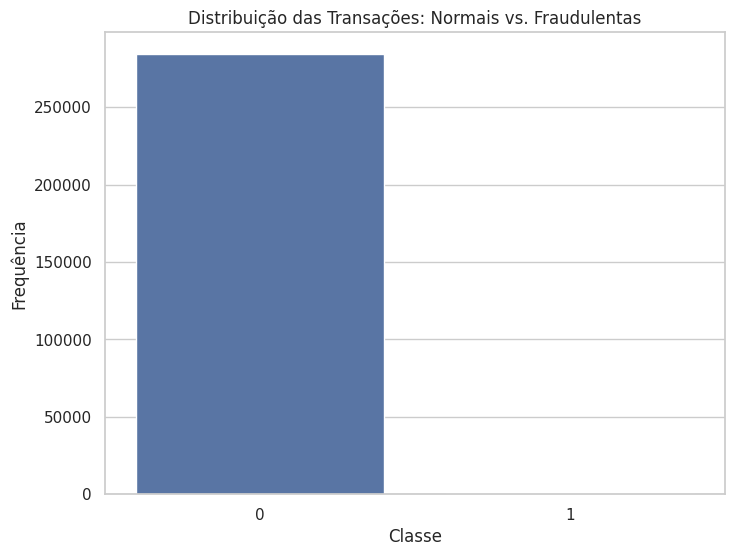


Estatísticas Descritivas para 'Amount':
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Estatísticas Descritivas para 'Amount' (Fraudes):
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [4]:
# Contagem e visualização da distribuição das classes
print("Distribuição das Classes (0: Normal, 1: Fraude):")
class_counts = df['Class'].value_counts()
print(class_counts)

# Visualização gráfica da distribuição das classes
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribuição das Transações: Normais vs. Fraudulentas')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

# Análise descritiva da coluna 'Amount'
print("\nEstatísticas Descritivas para 'Amount':")
print(df['Amount'].describe())

# Análise descritiva da coluna 'Amount' para transações fraudulentas
print("\nEstatísticas Descritivas para 'Amount' (Fraudes):")
print(df[df['Class'] == 1]['Amount'].describe())

In [5]:
# Instanciando o scaler
scaler = StandardScaler()

# Criando uma cópia do DataFrame para o pré-processamento
df_scaled = df.copy()

# Aplicando a normalização nas colunas 'Amount' e 'Time'
df_scaled['Amount'] = scaler.fit_transform(df_scaled['Amount'].values.reshape(-1, 1))
df_scaled['Time'] = scaler.fit_transform(df_scaled['Time'].values.reshape(-1, 1))

print("Cabeçalho do DataFrame após a normalização de 'Amount' e 'Time':")
print(df_scaled.head())

Cabeçalho do DataFrame após a normalização de 'Amount' e 'Time':
       Time        V1        V2        V3        V4        V5        V6  \
0 -1.996583 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -1.996583  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -1.996562 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -1.996562 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -1.996541 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267   

   

In [6]:
# Separando as features (X) e o alvo (y)
X = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

# Calculando a proporção de fraudes para o parâmetro 'contamination'
fraud_proportion = class_counts[1] / len(df)
print(f"Proporção de Fraude (Contamination): {fraud_proportion:.5f}")

# Criando e treinando o modelo Isolation Forest
# n_estimators: número de árvores na floresta
# max_samples: número de amostras para treinar cada árvore
# contamination: proporção esperada de anomalias
# random_state: para reprodutibilidade
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=fraud_proportion, random_state=42, n_jobs=-1)

print("\nTreinando o modelo Isolation Forest...")
model.fit(X)
print("Treinamento concluído.")

Proporção de Fraude (Contamination): 0.00173

Treinando o modelo Isolation Forest...
Treinamento concluído.



Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.26      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807


Matriz de Confusão:


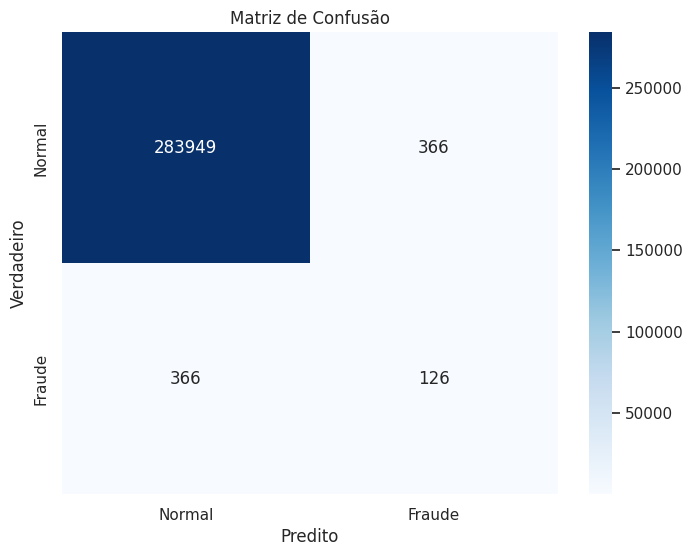


Acurácia do Modelo: 99.74%


In [7]:
# Realizando as predições no mesmo conjunto de dados
# O modelo retorna 1 para inliers e -1 para outliers (anomalias)
predictions = model.predict(X)

# Mapeando as predições para o nosso formato de classe (0: Normal, 1: Fraude)
# -1 (outlier) vira 1 (fraude)
#  1 (inlier)  vira 0 (normal)
y_pred = [1 if p == -1 else 0 for p in predictions]

# Avaliando a performance do modelo
print("\nRelatório de Classificação:")
print(classification_report(y, y_pred))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# A acurácia não é a melhor métrica para dados desbalanceados, mas vamos calculá-la
accuracy = accuracy_score(y, y_pred)
print(f"\nAcurácia do Modelo: {accuracy * 100:.2f}%")

In [8]:
# Lista de valores de contamination para testar
# Vamos testar o valor original, um valor maior e um bem maior
contamination_levels = [0.00173, 0.01, 0.05]

# Preparando os dados (mesmos da etapa anterior)
X = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

print("Iniciando a otimização do hiperparâmetro 'contamination'...\n")

for contamination_value in contamination_levels:
    print(f"--- Testando com contamination = {contamination_value} ---")

    # Criando e treinando o modelo com o novo valor
    model_opt = IsolationForest(n_estimators=100,
                                max_samples='auto',
                                contamination=contamination_value,
                                random_state=42,
                                n_jobs=-1)

    model_opt.fit(X)

    # Realizando as predições
    predictions_opt = model_opt.predict(X)
    y_pred_opt = [1 if p == -1 else 0 for p in predictions_opt]

    # Avaliando e imprimindo os resultados
    print(classification_report(y, y_pred_opt))

    # Imprimindo a matriz de confusão para análise detalhada
    cm_opt = confusion_matrix(y, y_pred_opt)
    print("Matriz de Confusão:")
    print(cm_opt)

    recall_score = cm_opt[1][1] / (cm_opt[1][1] + cm_opt[1][0])
    print(f"Recall para Fraudes: {recall_score:.2f}\n")

Iniciando a otimização do hiperparâmetro 'contamination'...

--- Testando com contamination = 0.00173 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.26      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807

Matriz de Confusão:
[[283948    367]
 [   366    126]]
Recall para Fraudes: 0.26

--- Testando com contamination = 0.01 ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.10      0.59      0.17       492

    accuracy                           0.99    284807
   macro avg       0.55      0.79      0.58    284807
weighted avg       1.00      0.99      0.99    284807

Matriz de Confusão:
[[281755   2560]
 [   203    289]]
Recall para Fraudes: 0.59

--- Testando com contamination = 0

In [9]:
import joblib

# Definindo o melhor hiperparâmetro encontrado
best_contamination = 0.01

# Criando o modelo final com o melhor parâmetro
final_model = IsolationForest(n_estimators=100,
                              max_samples='auto',
                              contamination=best_contamination,
                              random_state=42,
                              n_jobs=-1)

# Treinando o modelo final com os dados
print(f"Treinando o modelo final com contamination = {best_contamination}...")
final_model.fit(X)
print("Treinamento concluído.")

# Definindo o caminho e o nome do arquivo para salvar o modelo
model_save_path = '/content/drive/MyDrive/Projetos/Projetos - Ciência de Dados/Detecção de Fraudes em Transações Bancárias/isolation_forest_model.joblib'

# Salvando o modelo no arquivo
joblib.dump(final_model, model_save_path)

print(f"\nModelo salvo com sucesso em: {model_save_path}")

# Verificação opcional: Carregar o modelo e verificar se funciona
print("\nVerificando o modelo salvo...")
loaded_model = joblib.load(model_save_path)

# Pegando uma amostra dos dados para testar o modelo carregado
sample_data = X.head(1)
prediction = loaded_model.predict(sample_data)

print(f"Predição em uma amostra de dados com o modelo carregado: {'Fraude' if prediction[0] == -1 else 'Normal'}")

Treinando o modelo final com contamination = 0.01...
Treinamento concluído.

Modelo salvo com sucesso em: /content/drive/MyDrive/Projetos/Projetos - Ciência de Dados/Detecção de Fraudes em Transações Bancárias/isolation_forest_model.joblib

Verificando o modelo salvo...
Predição em uma amostra de dados com o modelo carregado: Normal


# Resumo Executivo e Conclusões Finais

## Contexto do Problema
O objetivo deste projeto foi desenvolver um modelo de Machine Learning para identificar transações de cartão de crédito fraudulentas em um dataset altamente desbalanceado, onde menos de 0.2% das transações eram fraudes. O principal desafio era maximizar a detecção de fraudes (verdadeiros positivos) minimizando o impacto operacional de alarmes falsos (falsos positivos).

## Abordagem e Metodologia
Utilizamos o algoritmo não supervisionado **Isolation Forest**, ideal para detecção de anomalias. A metodologia seguiu os seguintes passos:
1.  **Análise Exploratória:** Confirmação do desbalanceamento extremo e análise das features.
2.  **Pré-processamento:** Normalização das features `Time` e `Amount` para garantir a mesma escala.
3.  **Modelagem Baseline:** Treinamento de um modelo inicial com o parâmetro `contamination` ajustado para a proporção real de fraudes no dataset.
4.  **Otimização de Hiperparâmetros:** Teste iterativo de diferentes valores de `contamination` para analisar o trade-off entre Precisão e Recall.

## Resultados e Decisões
O modelo baseline, apesar de apresentar uma acurácia de 99.74%, demonstrou um **Recall de apenas 26%** para a classe de fraude, sendo ineficaz para o objetivo de negócio.

A otimização do parâmetro `contamination` revelou um claro trade-off:
-   `contamination=0.01`: **Recall de 59%**. A detecção de fraudes mais do que dobrou, ao custo de um aumento gerenciável de falsos positivos.
-   `contamination=0.05`: **Recall de 85%**. Excelente detecção de fraudes, porém com um número de falsos positivos (13.824) que seria operacionalmente inviável.

**O modelo final foi selecionado com `contamination=0.01`**, por representar o melhor equilíbrio entre a eficácia na detecção de fraudes e o impacto operacional.

## Conclusão e Próximos Passos
Este projeto demonstrou com sucesso a aplicação do Isolation Forest para detecção de fraudes. O modelo final foi salvo no arquivo `isolation_forest_model.joblib` e está pronto para ser integrado a um sistema de produção via API.

Como próximos passos para evoluir o projeto, sugere-se:
-   **Experimentar outros algoritmos:** Comparar a performance com Local Outlier Factor (LOF) ou One-Class SVM.
-   **Engenharia de Features:** Criar novas features a partir das existentes para tentar melhorar a separabilidade entre as classes.
-   **Deploy em Nuvem:** Criar uma API RESTful com Flask/FastAPI e implantá-la na AWS usando serviços como Lambda ou EC2 para realizar predições em tempo real.